# Specific Test IV. Diffusion Models 

## Import Libraries

In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.models as models

from torch import optim
from tqdm import tqdm
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance


import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import math

/home/babby/miniconda3/envs/oc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

Data Visualization

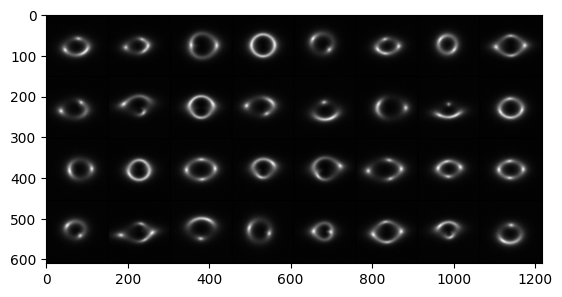

In [2]:
folder_path = 'Samples/Samples'  

images = []
for i in range(1,33):
    file_path = os.path.join(folder_path, f'sample{i}.npy') 
    image = np.load(file_path)
    images.append(torch.from_numpy(image))

grid = make_grid(images)
ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
plt.imshow(ndarr, cmap='gray')

Custom Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.root_dir, file_name)
        data = np.load(file_path)
        data = torch.from_numpy(data).float()
        if self.transform:
            data = self.transform(data)
        
        return data


## Model

### Unet

In [3]:
# Self attention module, picked straight from UNet architecture and modified
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=128):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=128):
        super().__init__()
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)
        self.bot1 = DoubleConv(256, 256)
        self.bot3 = DoubleConv(256, 256)
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        # Sinusoidal embedding
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)

        x4 = self.bot1(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        output = self.outc(x)
        return output

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)

### Diffusion

In [4]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=128, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        return x

    def cal_fid(self, model, train_dl, device):
        fid = FrechetInceptionDistance(feature=2048, reset_real_features = False, normalize = True).to(device)
        model.eval()
        n = 100
        with torch.no_grad():
            fake_imgs = self.sample(model, n)

        image_list = []
        num_images_to_sample = 100  # The number of images you want to sample
        total_sampled = 0
        
        # Sample a specific number of images (1000 in this example)
        for i, data in enumerate(train_dl):
            images = data
            image_list.append(images)
            total_sampled += images.size(0)  
            if total_sampled >= num_images_to_sample:
                break
        
        # Concatenate the list of images into a single tensor
        image_tensor = torch.cat(image_list[:num_images_to_sample], dim=0)
        real_imgs = image_tensor[0:100, :, :, :]
        
        real_imgs = real_imgs.to(device)
        real_imgs_rgb = self.convert_to_rgb(real_imgs, device)  # Convert to RGB
        fake_imgs_rgb = self.convert_to_rgb(fake_imgs, device)  # Convert to RGB
        fid.update(real_imgs_rgb, real=True)
        fid.update(fake_imgs_rgb, real=False)
        score = fid.compute()
        return score

    def convert_to_rgb(self, images, device):
    
        colormap = cm.viridis
        input_rgb_list = []
        for image in images:
            # Apply colormap
            image = image.cpu()
            input_rgb = colormap(image.numpy())  
            # Keep only RGB channels
            input_rgb = input_rgb[0, :, :, :3]
            # Convert numpy array back to tensor and permute dimensions to (channels, height, width)
            input_rgb_tensor = torch.from_numpy(input_rgb.astype(np.float32)).permute(2, 0, 1)
            input_rgb_list.append(input_rgb_tensor)
        
        # Stack the list of tensors along the batch dimension
        input_rgb_batch = torch.stack(input_rgb_list, dim=0).to(device)
    
        return input_rgb_batch
        
def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    plt.imshow(ndarr, cmap='gray')
    plt.savefig(path)

def Plot(x_sampled,fig_size = (6,6)):
    grid = make_grid(x_sampled.cpu(), nrow=10)
    if fig_size is not None:
        plt.figure(figsize= fig_size)
    plt.imshow(grid.permute(1,2,0).detach().numpy(), cmap='gray')
    plt.show()

## Training Loop

Starting epoch 0:


100%|██████████| 417/417 [04:04<00:00,  1.70it/s]
999it [02:20,  7.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Starting epoch 1:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 2:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 3:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 4:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 5:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 6:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 7:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 8:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 9:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 10:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 11:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 12:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 13:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 14:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 15:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 16:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 17:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 18:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 19:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 20:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 21:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 22:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 23:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 24:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 25:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]
999it [02:20,  7.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Starting epoch 26:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 27:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 28:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 29:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 30:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 31:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 32:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 33:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 34:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 35:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 36:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 37:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 38:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 39:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 40:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 41:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 42:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 43:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 44:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 45:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 46:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 47:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 48:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 49:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 50:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]
999it [02:20,  7.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Starting epoch 51:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 52:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 53:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 54:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 55:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 56:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 57:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 58:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 59:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 60:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 61:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 62:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 63:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 64:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 65:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 66:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 67:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 68:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 69:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 70:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 71:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 72:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 73:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 74:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 75:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]
999it [02:20,  7.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Starting epoch 76:


100%|██████████| 417/417 [04:02<00:00,  1.72it/s]


Starting epoch 77:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 78:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 79:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 80:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 81:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 82:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 83:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 84:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 85:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 86:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 87:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 88:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 89:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 90:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 91:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 92:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 93:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 94:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 95:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 96:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 97:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 98:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


Starting epoch 99:


100%|██████████| 417/417 [04:03<00:00,  1.71it/s]


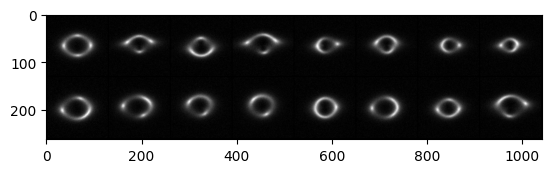

In [6]:
lr = 3e-4
epochs = 100
image_size = 128
batch_size = 24
plot_freq = 25
Data_dir = 'Samples/Samples'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
        transforms.Resize(image_size),
])
# Create an instance of your dataset
dataset = CustomDataset(root_dir=Data_dir, transform=transform)

# Create a DataLoader for your dataset
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                 steps_per_epoch=len(data_loader), epochs=epochs)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=image_size, device=device)
l = len(data_loader)

for epoch in range(epochs):
    print(f"Starting epoch {epoch}:")
    pbar = tqdm(data_loader)
    for i, (images) in enumerate(pbar):
        
        images = images.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        schedular.step()

    if epoch % plot_freq == 0: 
        sampled_images = diffusion.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("Results", f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("Models",  f"ckpt_128.pt"))

## Evaluation

Quantitative metrics : Fréchet Inception Distance (FID) 

In [6]:
checkpoint = "Models/ckpt_128.pt"
model = UNet().to(device)
model.load_state_dict(torch.load(checkpoint))
FID_Score = diffusion.cal_fid(model, data_loader, device)
print("FID score:",FID_Score)

999it [13:34,  1.23it/s]


FID score: tensor(23.7581, device='cuda:2')


Plotting(Qualitative assessment)

999it [06:51,  2.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


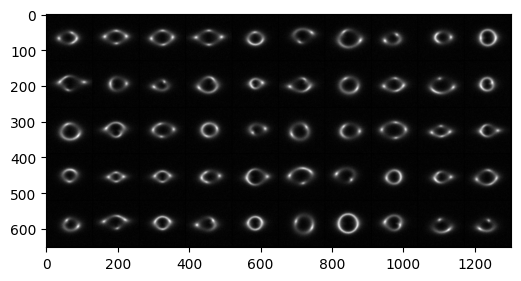

In [12]:
sampled_images = diffusion.sample(model, 50)
Plot(sampled_images)

## Discussion

In the pursuit of simulating realistic strong gravitational lensing images, I employed a generative model utilizing a diffusion U-Net architecture. This architecture integrates a U-Net with attention mechanisms, allowing for effective feature extraction and preservation of spatial information crucial for accurate image synthesis. To optimize the model's performance, I employed the AdamW optimizer coupled with a one-cycle learning rate scheduler, facilitating stable and efficient convergence throughout training. With a total of 100 epochs and a learning rate set at 3e-4, the model was trained on a dataset of gravitational lensing images. Evaluation of the model's fidelity was conducted using the Fréchet Inception Distance (FID) metric, calculated over a set of 100 generated images. Through this approach, the diffusion U-Net architecture demonstrates its efficacy in generating high-fidelity gravitational lensing images